<a href="https://colab.research.google.com/github/DanileRond/Computer-Vision-with-Deep-Learning/blob/main/CV_fundamental_matrix_Navarrete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Computer Vision with Deep Learning**
# Estimation of the Fundamental Matrix with the 8-point algorithm

2021 - Javier Ruiz Hidalgo - [GPI @ IDEAI](https://imatge.upc.edu/web/) Research group [ETSETB – UPC.TelecosBCN](https://telecos.upc.edu/ca)

---

In this practical work we will address the problem of estimating the fundamental matrix between two images. To do this, the characteristic points will be detected in both images and then, correspondences between points will be established. Using these correspondences, the fundamental matrix can be estimated. Answer the questions briefly on the provided document, creating and showing pictures if necessary. 


We will be using the images "coco_left.png" and "coco_right.png". First of all download them from ATENEA together with this file and upload them to the Colaboratory notebook.

In [13]:
# The SIFT patent has exprired recently. In the last versions of
# OpenCV, the SIFT functionality is already in the main module
# Install a new version of opencv
# This can be removed when Colab uses a modern enough version of opencv by default
!pip install opencv-contrib-python==4.4.0.46

Display the images to check they have been uploaded correctly:

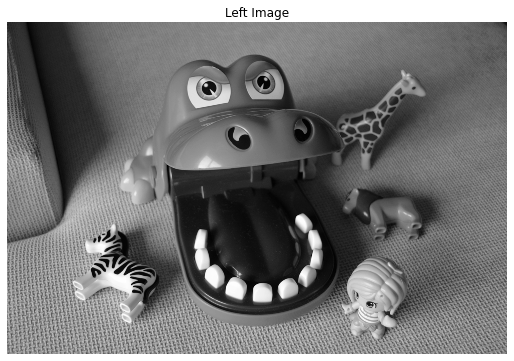

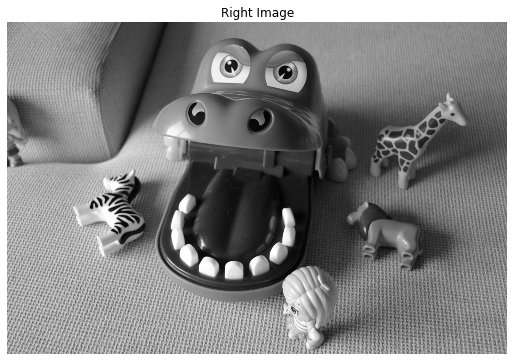

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# You can change these values to increase/decrease the size of the images in the notebook
plt.rcParams['figure.figsize'] = [15, 8] 

# Read the files from notebook disk
img_left = cv2.imread('coco_left.png',0)  # left image
img_right = cv2.imread('coco_right.png',0) # right image

# Function to display one image
def display_image(img, title='', size=None, show_axis=False):
    plt.gray()
    if not show_axis:
      plt.axis('off')
    h = plt.imshow(img, interpolation='none')
    if size:
        dpi = h.figure.get_dpi()/size
        h.figure.set_figwidth(img.shape[1] / dpi)
        h.figure.set_figheight(img.shape[0] / dpi)
        h.figure.canvas.resize(img.shape[1] + 1, img.shape[0] + 1)
        h.axes.set_position([0, 0, 1, 1])
        if show_axis:
            h.axes.set_xlim(-1, img.shape[1])
            h.axes.set_ylim(img.shape[0], -1)
    plt.grid(False)
    plt.title(title)  
    plt.show()


# Plot left image
display_image(img_left, 'Left Image', size=0.5)

# Plot right image
display_image(img_right, 'Right Image', size=0.5)


# Manual correspondences
In this part you will estimate the fundamental matrix between two images using 8 manual correspondences. 

Select 8 correspondences from each image. You can use any external program (such as gimp, photoshop or paint) to open the files and select the coordinates for the correspondences. For instance one correspondence could be in the eye of the jiraffe which corresponds to coordinates (815,133) in the left image and (893,186) in the right image. 

<font color=red>**Question 1: Insert the missing 7 correspondences into the code below:**</font>

In [15]:
# Select correspondences and write them in two variables in the format [[x0,y0],[x1,y1],...] !!!!
# TODO -----------------------------------
# Add values for missing correspondences
manual_correspondences_left = np.array([[815,133],[513,122],[246,506],[750,549],[684,355],[297,353],[420,532],[100,404]])
manual_correspondences_right = np.array([[893,186],[557,101],[222,388],[584,565],[699,377],[350,274],[338,454],[208,272]])
# TODO -----------------------------------

We will plot the 8 correspondences using the provided function *plot_correspondences*:

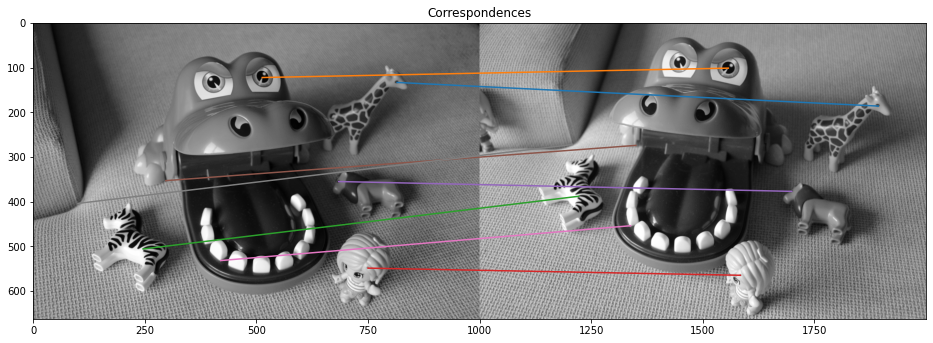

In [16]:
# You can change these values to increase/decrease the size of the images in the notebook
plt.rcParams['figure.figsize'] = [16, 8] 

def plot_correspondences(img1,pts1,img2,pts2):
  # Concat both images
  img = np.concatenate((img1, img2), axis=1)
  # Show images
  plt.imshow(img); plt.grid(False)
  ax = plt.gca()
  for p1,p2 in list(zip(pts1,pts2)):
    ax.plot([p1[0],p2[0]+img1.shape[1]],[p1[1],p2[1]])  
  plt.title('Correspondences')
  plt.show()
   
plot_correspondences(img_left,manual_correspondences_left,
                     img_right, manual_correspondences_right)

Compute the fundamental matrix using the 8-point algorithm and the manual correspondences you have obtained. We will use the provided function *compute_fundamental_matrix_8point* and we will study the difference using normalization before applying the 8-point algorithm:

In [17]:

def compute_fundamental_matrix_8points(pts1, pts2, norm=True):
    """    Computes the fundamental matrix from corresponding points 
        (pts1,pts2 n*2 arrays) using the 8 point algorithm.
        Each row in the A matrix below is constructed as
        [u*u', v*u', u', u*v', v*v', v', u, v, 1] """
    
    # Check dimensions
    n = pts1.shape[0]
    if pts2.shape[0] != n:
        raise ValueError("Number of points don't match.")
    
    # Normalize points
    if norm:
      # normalize image coordinates
      m1 = np.mean(pts1,axis=0)
      S1 = np.sqrt(2) / np.std(pts1)
      T1 = np.array([[S1,0,-S1*m1[0]],[0,S1,-S1*m1[1]],[0,0,1]])
      xx1 = np.concatenate((pts1,np.ones((1,n)).transpose()),axis=1)
      pts1 = np.dot(T1,xx1.transpose()).transpose()
      
      m2 = np.mean(pts2,axis=0)
      S2 = np.sqrt(2) / np.std(pts2)
      T2 = np.array([[S2,0,-S2*m2[0]],[0,S2,-S2*m2[1]],[0,0,1]])
      xx2 = np.concatenate((pts2,np.ones((1,n)).transpose()),axis=1)
      pts2 = np.dot(T2,xx2.transpose()).transpose()
    
    # build matrix for equations
    A = np.zeros((n,9))
    for i in range(n):
        A[i] = [pts1[i,0]*pts2[i,0], pts1[i,1]*pts2[i,0], pts2[i,0], 
                pts1[i,0]*pts2[i,1], pts1[i,1]*pts2[i,1], pts2[i,1],
                pts1[i,0],           pts1[i,1],           1        ]
            
    # compute linear least square solution
    U,S,V = np.linalg.svd(A)
    F = V[-1].reshape(3,3)
        
    # make rank 2 by zeroing out last singular value
    U,S,V = np.linalg.svd(F)
    S[2] = 0
    F = np.dot(U,np.dot(np.diag(S),V))
    
    # reverse normalization
    if norm:
      F = np.dot(T2.T,np.dot(F,T1))
    
    return F/F[2,2]
  
print('F with manual correspondences not normalized:')
manual_F_nonorm = compute_fundamental_matrix_8points(manual_correspondences_left, manual_correspondences_right, norm=False)
print(manual_F_nonorm)

print('')
print('F with manual correspondences normalized:')
manual_F = compute_fundamental_matrix_8points(manual_correspondences_left, manual_correspondences_right, norm=True)
print(manual_F)

F with manual correspondences not normalized:
[[-5.57423243e-08 -3.17695270e-07  3.36379305e-05]
 [-1.84607098e-06  2.67128925e-06  8.28087320e-03]
 [-1.47960519e-03 -8.23559716e-03  1.00000000e+00]]

F with manual correspondences normalized:
[[-5.81984798e-08 -3.14706753e-07  4.65944606e-05]
 [-1.85787889e-06  2.68794209e-06  8.33230738e-03]
 [-1.47191971e-03 -8.29133830e-03  1.00000000e+00]]


Let's compare the resulting Fundamental matrices. First of all plot both images and draw the epipolar lines and correspondence points for both of them. You can use the provided functions *plotline* (to plot a line defined in homogeneus coodinates vector) and *plotpoint* (to plot points in images) below to draw both images. 

<font color=red>**Question 2: Add the missing code to the function *plot_epipolar_lines* BELOW to correctly plot correspondences and epipolar lines. Observe both fundamental matrices (with and without normalization) and comment here what do you think of the results:**</font>

<font color=blue>**As F gives the information about how the scene changes under the view point transform, we can see that in both images, both FM performes quite similar. Also every file and row do not varies much**</font>

[[-5.57423243e-08 -3.17695270e-07  3.36379305e-05]
 [-1.84607098e-06  2.67128925e-06  8.28087320e-03]
 [-1.47960519e-03 -8.23559716e-03  1.00000000e+00]]


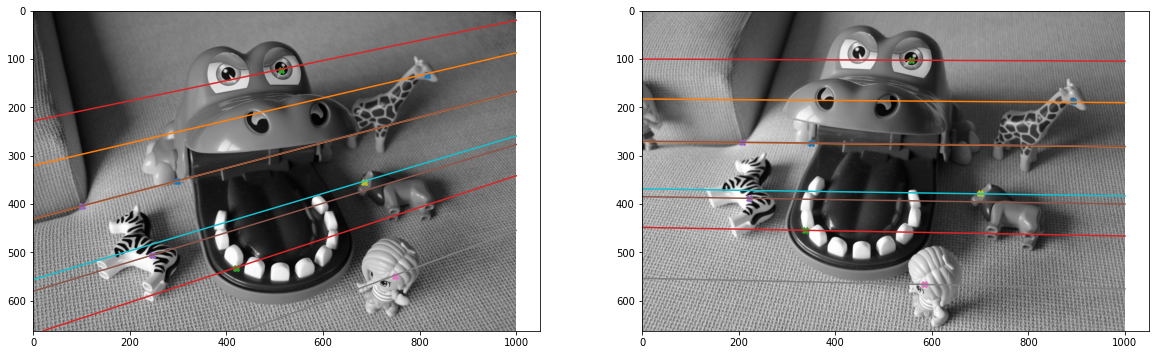

[[-5.81984798e-08 -3.14706753e-07  4.65944606e-05]
 [-1.85787889e-06  2.68794209e-06  8.33230738e-03]
 [-1.47191971e-03 -8.29133830e-03  1.00000000e+00]]


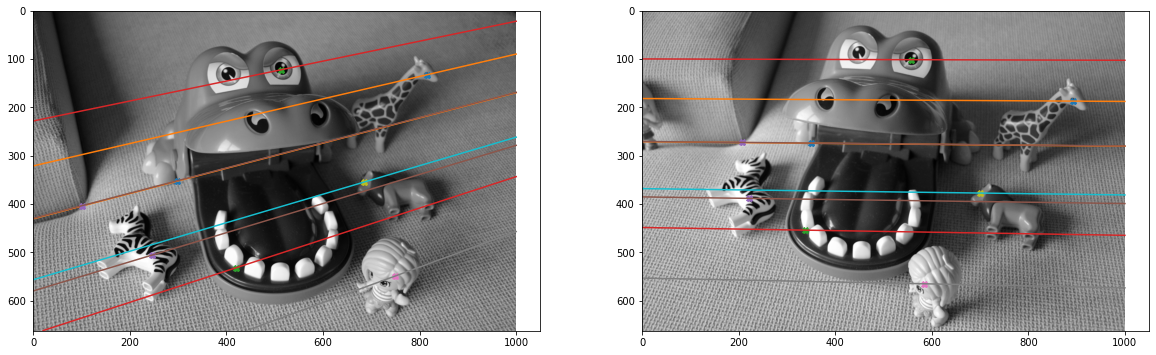

In [18]:
# You can change these values to increase/decrease the size of the images in the notebook
plt.rcParams['figure.figsize'] = [20, 10] 

# Function to plot points in images
def plotpoint(p):
  ax = plt.gca()
  ax.plot(p[0],p[1], 'X', markersize=6)

# Function to plot lines in images
def plotline(l):
  ax = plt.gca()
  xmin = 0
  xmax = img_left.shape[1]
  x = np.linspace(xmin,xmax)
  x.shape
  l.shape
  y = (l[0]*x+l[2])/(-1*l[1])
  ax.plot(x[(y>0) & (y<img_left.shape[0])],y[(y>0) & (y<img_left.shape[0])])

def plot_epipolar_lines(F,img1,pts1,img2,pts2):
  # Plot left image with correspondences and epipolar lines
  plt.subplot(121),plt.imshow(img1)
  plt.grid(False)
  print(F)

  for i,p in enumerate(pts1):
    plotpoint(p)
    # TODO -----------------------------------
    # Include code to plot epipolar lines !!!!
    point = np.append(pts2[i],1)
    F_trans = np.transpose(F)
    l = np.matmul(F_trans,point)
    plotline(l)
    # TODO -----------------------------------

  # Plot right image with correspondences and epipolar lines
  plt.subplot(122),plt.imshow(img2)
  plt.grid(False)
  for i,p in enumerate(pts2):
    plotpoint(p)
    # TODO -----------------------------------
    # Include code to plot epipolar lines !!!!
    point = np.append(pts1[i],1)
    l2 = np.matmul(F,point)
    plotline(l2)
    # TODO -----------------------------------
    # Include code to plot epipolar lines !!!!
    # TODO -----------------------------------


  plt.show()
  
plot_epipolar_lines(manual_F_nonorm,img_left,manual_correspondences_left,img_right,manual_correspondences_right)
plot_epipolar_lines(manual_F,img_left,manual_correspondences_left,img_right,manual_correspondences_right)

<font color=red>**Question 3: From the images above, are epipoles inside or outside of the images left and right?**</font>

<font color=blue>**It is clear that the epipoles are outside the images left and right. The epipolar lines are "parallel" between each other**</font>

Finally we will measure the error of the estimated Fundamental matrices in two ways: 1) directly using the expression p'Fp=0 (Algebraic Error) and 2) as the distance between the point and its correspondence epipolar line (Symmetric Epipolar Error).  (You can check this [paper](https://arxiv.org/abs/1706.07886) to further understand how to measure Fundamental matrix errors). In both cases you can average the results for all correspondence points. Notice that both errors should be 0 if the estimated Fundamental matrix is perfectly correct. 

<font color=red>**Question 4: Add missing code for the epipolar error. Print out both errors and discuss which has a more physical meaning**.</font>


<font color=blue>**The epipolar error has more physical meaning so it is the geometric distance between the epipolar lines and its respectives points. It is measured in pixels and we can see how due to the normalization it decreases considerably.
In the other hand, the algebraic distance error has no physical meaning so it is proved it is biased and tends to bring the epipoles towards the image center.**</font>

In [19]:
# Function to compute algebraic error 
def F_algebraic_error(F,pts1,pts2):
  algebraic_error = 0
  for p1,p2 in list(zip(pts1,pts2)):
    p1 = np.append(p1,1)
    p2 = np.append(p2,1)
    algebraic_error += np.abs(np.matmul(p2,np.matmul(F,p1)))
  return(algebraic_error/pts1.shape[0])

# Function to compute epipolar error
def F_epipolar_error(F,pts1,pts2):
  def distance_point_to_line(l,p):
    return(np.abs(l[0]*p[0]+l[1]*p[1]+l[2])/np.sqrt(l[0]*l[0]+l[1]*l[1]))
    
  epipolar_error = 0
  for p1,p2 in list(zip(pts1,pts2)):
    p1 = np.append(p1,1)
    p2 = np.append(p2,1)
    # TODO -----------------------------------
    # Add code here to compute the distance 
    # from each point p1, p2 to its correspondence
    # epipolar line and return the average
    # TODO -----------------------------------

    l1 = np.matmul(F.transpose(),p2)
    l2 = np.matmul(F,p1)
    
    epipolar_error += distance_point_to_line(l1,p1)
    epipolar_error += distance_point_to_line(l2,p2)
    
  return(epipolar_error / pts1.shape[0] / 2)
  
# Compute algebraic and epipolar errors for manual Fundamental Matrix
print('Algebraic error NONORM:')
print(F_algebraic_error(manual_F_nonorm,manual_correspondences_left,manual_correspondences_right))
print('Epipolar error NONORM:')
print(F_epipolar_error(manual_F_nonorm,manual_correspondences_left,manual_correspondences_right))

# Compute algebraic and epipolar errors for manual Fundamental Matrix
print('Algebraic error:')
print(F_algebraic_error(manual_F,manual_correspondences_left,manual_correspondences_right))
print('Epipolar error:')
print(F_epipolar_error(manual_F,manual_correspondences_left,manual_correspondences_right))

Algebraic error NONORM:
0.008364629651101477
Epipolar error NONORM:
1.0671625894924217
Algebraic error:
0.001978179694517912
Epipolar error:
0.2457665931815794


<font color=red>**Question 5: Which Fundamental matrix (with and without normalization) you think is more correct? Are errors coherent with the figure showing epipolar lines and correspondences in the previous section?**.</font>


<font color=blue>** Due to the least square methods are very sensitive and unestable, it is better to compute the FM from normalized input data. Therefore the normalized FM is more correct so it achieves a better accuracy.  **</font>

# Automatic correspondences
In this part you will estimate the fundamental matrix between the same two images but using automatically extracted correspondences. We will use the SIFT descriptor you review in Unit 1 of the course.

[<KeyPoint 0x7f2075d2d210>, <KeyPoint 0x7f2075b4a390>, <KeyPoint 0x7f2075cd1b70>, <KeyPoint 0x7f2075cd1ba0>, <KeyPoint 0x7f2075cd1b40>, <KeyPoint 0x7f2075cd1ea0>, <KeyPoint 0x7f2075cd1a20>, <KeyPoint 0x7f2075cd15d0>, <KeyPoint 0x7f2075cd19f0>, <KeyPoint 0x7f2075cd1240>, <KeyPoint 0x7f2075cd17b0>, <KeyPoint 0x7f2075cd1e40>, <KeyPoint 0x7f2075cd1cf0>, <KeyPoint 0x7f2075cd16c0>, <KeyPoint 0x7f2075cd1f90>, <KeyPoint 0x7f2075cd1720>, <KeyPoint 0x7f2075cd1fc0>, <KeyPoint 0x7f2075cd1a80>, <KeyPoint 0x7f2075cd19c0>, <KeyPoint 0x7f2075cd1d80>, <KeyPoint 0x7f2075a55e10>, <KeyPoint 0x7f2075a55de0>, <KeyPoint 0x7f2075a55e40>, <KeyPoint 0x7f2075a55a80>, <KeyPoint 0x7f2075c4e9f0>, <KeyPoint 0x7f2075c4e1e0>, <KeyPoint 0x7f2075c4e6f0>, <KeyPoint 0x7f2075c4eae0>, <KeyPoint 0x7f2075c4e090>, <KeyPoint 0x7f2075c4ecc0>, <KeyPoint 0x7f2075c4efc0>, <KeyPoint 0x7f2075c4e990>, <KeyPoint 0x7f2075c4e840>, <KeyPoint 0x7f2075c4e5a0>, <KeyPoint 0x7f2075c4e960>, <KeyPoint 0x7f2075c4edb0>, <KeyPoint 0x7f2075c4e2a0>, 

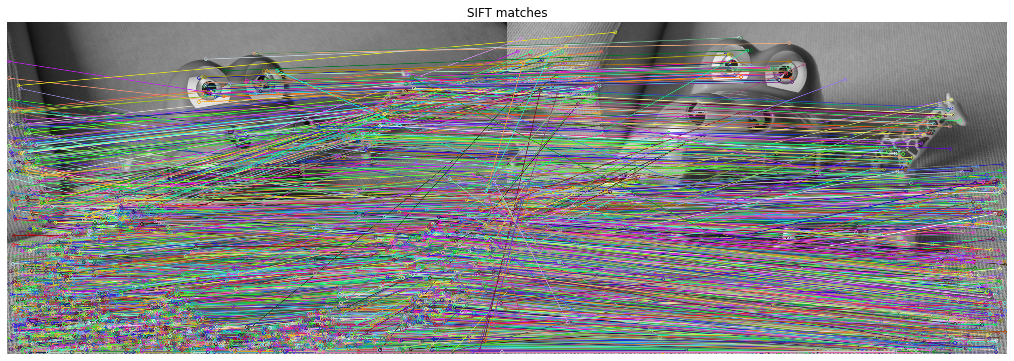

In [20]:
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(img_left,None)
kp2, des2 = sift.detectAndCompute(img_right,None)
print(kp1)
print(kp2)
# create BFMatcher object
bf = cv2.BFMatcher(crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# print the total number
print ('The number of matches is: {}'.format(len(matches)))

# Draw matches.
img12 = cv2.drawMatches(img_left,kp1,img_right,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

display_image(img12, 'SIFT matches', size=0.5)


<font color=red>**Question 6: Review the obtained matches, are there any obvious errors?**</font>

<font color=blue>**Yes, it has several errors as the symmetric error in crocodile's eyes.**</font>

As you can observe, we obtain a lot of matches from the SIFT correspondences. First of all, we will arrange the matches into correspondences in a similar format as the manual ones. 

<font color=red>**Question 7: Modify the code below so only the first 1000 matches with lower distance are used**</font>

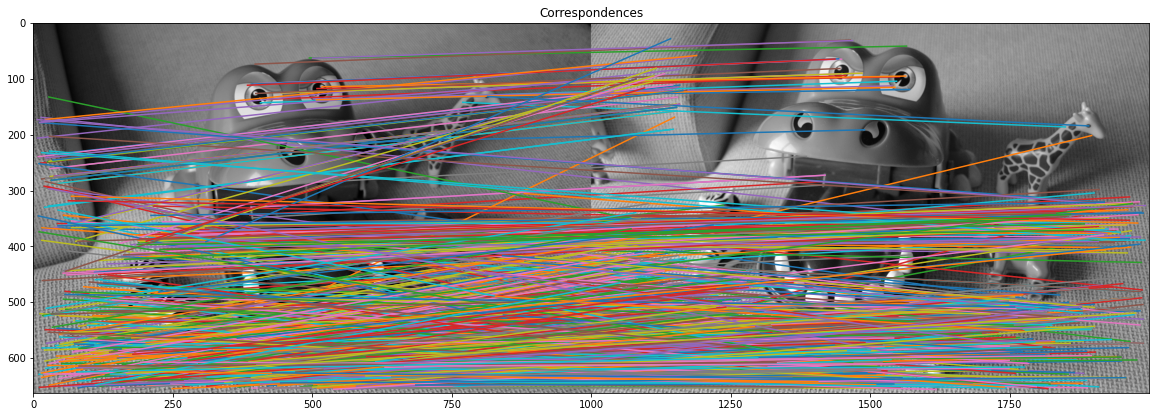

In [39]:
# Obtained list of correspondences from matched points
sift_correspondences_left = []
sift_correspondences_right = []
distance = []
firstmatches = []
for i,m in enumerate(matches):
  sift_correspondences_left.append(kp1[m.queryIdx].pt)
  sift_correspondences_right.append(kp2[m.trainIdx].pt)
  distance.append([m.distance,i])
sift_correspondences_left = np.array(sift_correspondences_left)
sift_correspondences_right = np.array(sift_correspondences_right)
distance=np.array(distance)
distance = sorted(distance, key=lambda x: x[0])


left = []
right = []
for i in range(1000):
 # print(int(distance[i][1]))
  firstmatches.append(distance[i][1])
  left.append(sift_correspondences_left[int(distance[i][1])])
  right.append(sift_correspondences_right[int(distance[i][1])])

sift_correspondences_left = left
sift_correspondences_right = right

sift_correspondences_left = np.array(sift_correspondences_left)
sift_correspondences_right = np.array(sift_correspondences_right)
plot_correspondences(img_left,sift_correspondences_left,
                     img_right, sift_correspondences_right)



Now, we will obtain the fundamental matrix using the 8-point algorithm not using and using RANSAC from the obtained matches. Furthermore, we will obtained the inliers for the correspondences obtained with RANSAC. 

All correspondences:
(1000, 2)
RANSAC correspondences:
(522, 2)


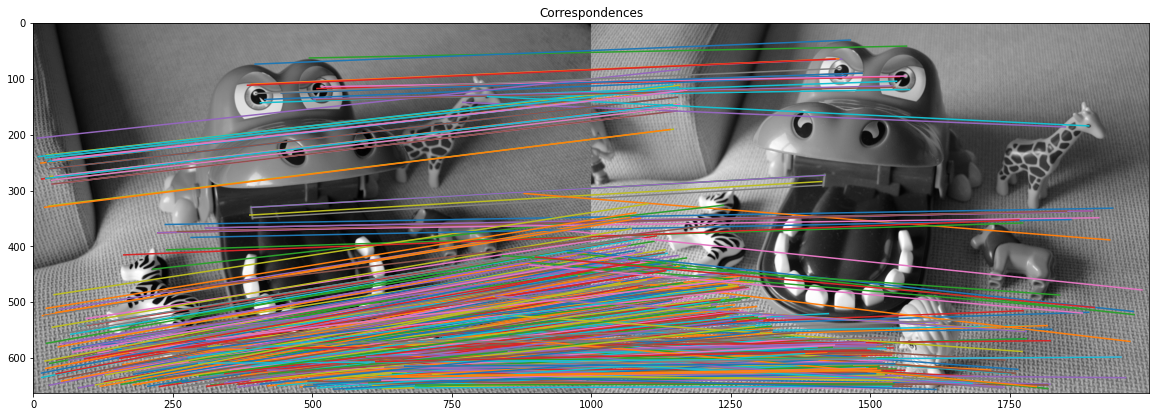

In [44]:

# Function to compute epipolar error
def epipolar_error(F,pts1,pts2):
  l2 = np.matmul(F,np.array([pts1[0],pts1[1],1]))
  l1 = np.matmul(F.T,np.array([pts2[0],pts2[1],1]))  
  d1 = np.abs(l1[0]*pts1[0]+l1[1]*pts1[1]+l1[2])/np.sqrt(l1[0]*l1[0]+l1[1]*l1[1])
  d2 = np.abs(l2[0]*pts2[0]+l2[1]*pts2[1]+l2[2])/np.sqrt(l2[0]*l2[0]+l2[1]*l2[1])
  return ((d1+d2)/2)

def compute_fundamental_matrix_8points_ransac(pts1,pts2,iter=1000,thres=3.0,conf=0.99):
    maxInliers = []
    for i in range(iter):
        # find 8 random correspondences
        r = np.random.randint(pts1.shape[0], size=10)
        
        # compute F
        F = compute_fundamental_matrix_8points(pts1[r,:],pts2[r,:])

        # Compute inliers
        inliers = []
        for i in range(len(pts1)):
            d = epipolar_error(F,pts1[i,:],pts2[i,:])
            if d < thres:
                inliers.append(i)
                
        if len(inliers) > len(maxInliers):
            maxInliers = inliers

        if len(maxInliers) > (len(pts1)*conf):
            break
            
    # Re-compute F with all inliers
    F = compute_fundamental_matrix_8points(pts1[maxInliers],pts2[maxInliers])
    return F, maxInliers

sift_F = compute_fundamental_matrix_8points(sift_correspondences_left, sift_correspondences_right)
sift_ransac_F,inliers = compute_fundamental_matrix_8points_ransac(sift_correspondences_left, sift_correspondences_right)


sift_ransac_correspondences_left = sift_correspondences_left[inliers,:]
sift_ransac_correspondences_right = sift_correspondences_right[inliers,:]

print('All correspondences:')
print(sift_correspondences_left.shape)
print('RANSAC correspondences:')
print(sift_ransac_correspondences_left.shape)


plot_correspondences(img_left,sift_ransac_correspondences_left,
                     img_right, sift_ransac_correspondences_right)

<font color=red>**Question 8: How many outliers does the RANSAC method discards in the fundamental matrix computation? Why does the number of outliers change between executions?**</font>

<font color=blue>**It descards nearly 500 outliers (1000 - 504). Due to it selects a random sub-set every time**</font>


<font color=red>**Question 9: Discuss the advantages of using RANSAC in the fundamental matrix computation.**</font>


<font color=blue>**RANSAC exploit heuristics, discard outliers and reestimate F using inliers**</font>

Compute the symmetric epipolar error for the new 2 fundamental matrices: 


105.40459963656684
0.27835587601423706
[[-2.29989157e-07 -1.80842743e-06 -2.48930416e-04]
 [-7.39795299e-07  2.04708601e-07  9.61859627e-03]
 [-1.20822504e-03 -8.16665133e-03  1.00000000e+00]]


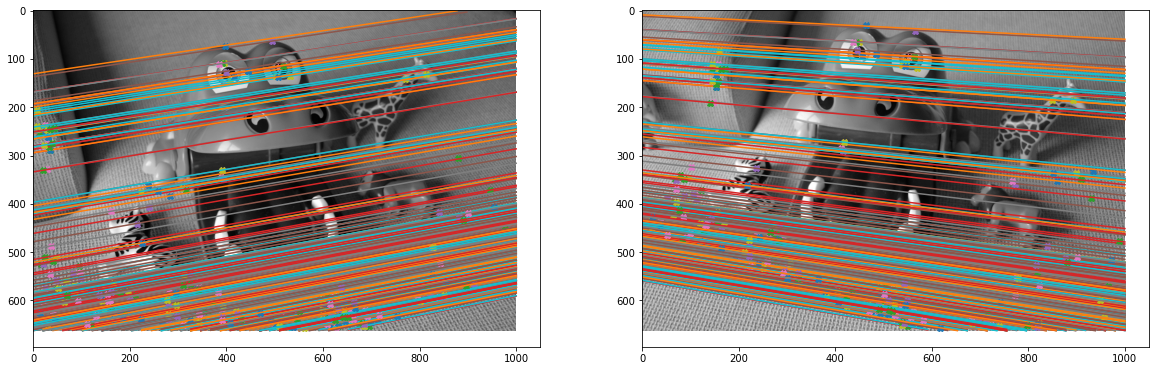

In [45]:

# Compute epipolar error for orb Fundamental Matrix
print(F_epipolar_error(sift_F,sift_ransac_correspondences_left,sift_ransac_correspondences_right))

# Compute epipolar error for orb + ransac Fundamental Matrix
print(F_epipolar_error(sift_ransac_F,sift_ransac_correspondences_left,sift_ransac_correspondences_right))

plot_epipolar_lines(sift_ransac_F,img_left,sift_ransac_correspondences_left,img_right,sift_ransac_correspondences_right)

<font color=red>**Question 10: From the results discuss the advantages and disadvantages of obtaining correspondences manually or automatically.**</font>

<font color=blue>**With the automatically method you can obtain more correspondences than using the manually. They are computed so well and you are able to discard the outlies. You can In the other hand you have less control about which correspondences are you selecting. You are also increasing the noise effects and the false matches. Finally due to the aleatory of RANSAC you can not sure about the result.**</font>